<a href="https://colab.research.google.com/github/MHzNug/Project-Analisis-Data-Gambar/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Muhammad Husni Zahran Nugrahanto
- **Email:** mhusny1604@gmail.com
- **ID Dicoding:** mhznug

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from PIL import Image

## Data Preparation

### Data Loading

In [2]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


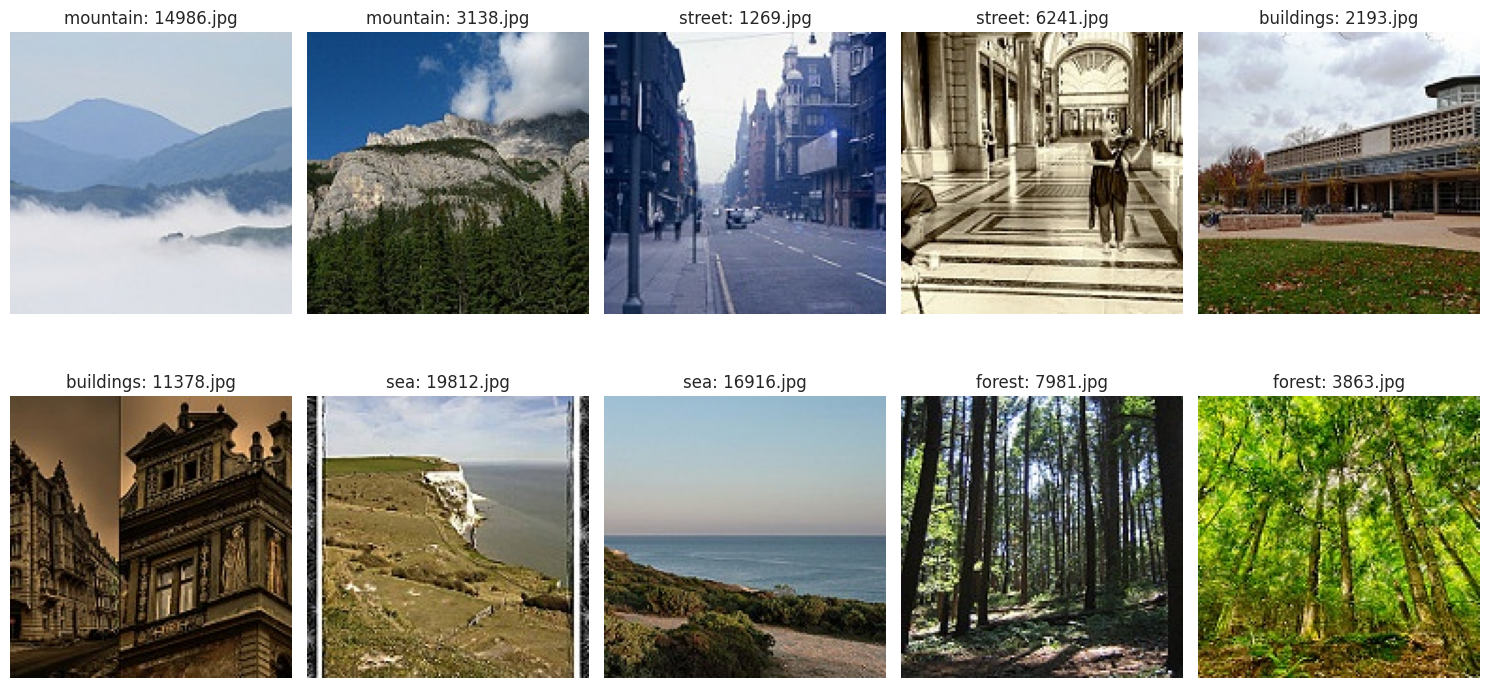

In [32]:
# Tentukan path dataset yang benar
dataset_path = path  # Path yang diperoleh dari kagglehub

# Tentukan folder train dan test
train_folder = os.path.join(dataset_path, 'seg_train', 'seg_train')
test_folder = os.path.join(dataset_path, 'seg_test', 'seg_test')

# Ambil semua subfolder (segmen) dalam direktori 'seg_train' dan 'seg_test'
train_subfolders = [f for f in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, f))]
test_subfolders = [f for f in os.listdir(test_folder) if os.path.isdir(os.path.join(test_folder, f))]

# Gabungkan semua subfolder dari train dan test
all_subfolders = train_subfolders + test_subfolders

# Ambil gambar dari setiap subfolder
all_images = []
for subfolder in all_subfolders:
    # Tentukan path subfolder
    if subfolder in train_subfolders:
        subfolder_path = os.path.join(train_folder, subfolder)
    else:
        subfolder_path = os.path.join(test_folder, subfolder)

    # Ambil file gambar dari subfolder
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Pilih hingga 10 gambar pertama dari setiap subfolder
    all_images.extend(image_files[:2])  # Ambil 2 gambar pertama dari setiap folder

# Tentukan jumlah kolom dan baris untuk menampilkan 10 gambar
columns = 5  # 5 gambar per baris
rows = 2  # 2 baris untuk menampilkan 10 gambar

# Tampilkan gambar-gambar tersebut
plt.figure(figsize=(15, 8))  # Ukuran gambar yang lebih besar dan proporsional

# Tampilkan hanya 10 gambar
for i, image_file in enumerate(all_images[:10]):  # Hanya tampilkan 10 gambar
    # Tentukan subfolder dan path gambar
    subfolder = all_subfolders[i // 2]  # Menyesuaikan subfolder dari gambar yang diambil
    if subfolder in train_subfolders:
        img_path = os.path.join(train_folder, subfolder, image_file)
    else:
        img_path = os.path.join(test_folder, subfolder, image_file)

    # Baca dan tampilkan gambar
    img = Image.open(img_path)
    plt.subplot(rows, columns, i + 1)  # Menyesuaikan dengan jumlah kolom dan baris
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{subfolder}: {image_file}")

plt.tight_layout()  # Untuk merapikan jarak antar gambar
plt.show()


<ipython-input-33-194056dd769f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot_data = sns.countplot(y=Label, palette='viridis', order=label_counts.index)


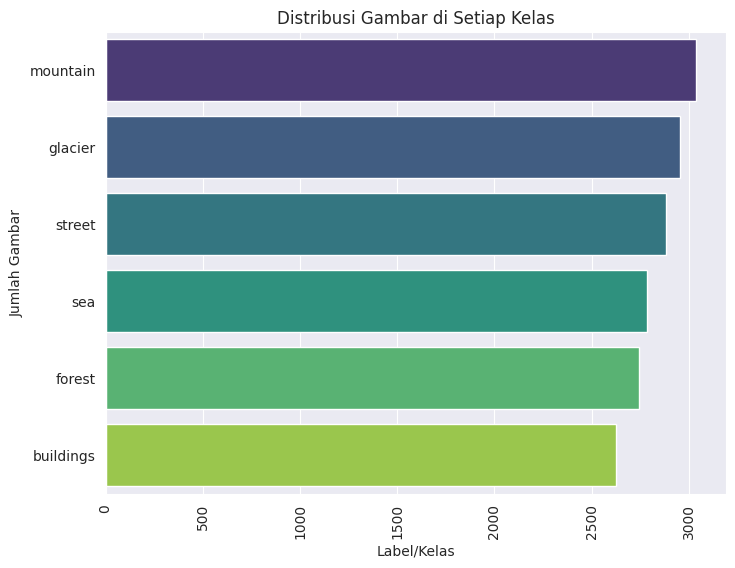

In [33]:
# Gabungkan semua subfolder dari train dan test dengan path lengkap
all_subfolders = [os.path.join(train_folder, subfolder) for subfolder in train_subfolders] + \
                  [os.path.join(test_folder, subfolder) for subfolder in test_subfolders]

# Daftar untuk menyimpan data
file_name = []
labels = []
full_path = []

# Looping untuk mendapatkan nama file, path file, dan label dari setiap gambar
for folder in all_subfolders:
    for file in os.listdir(folder):
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Memastikan hanya file gambar
            full_path.append(os.path.join(folder, file))
            labels.append(os.path.basename(folder))  # Mengambil nama subfolder sebagai label
            file_name.append(file)

# Membuat DataFrame
dataset = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Hitung jumlah gambar untuk setiap kelas
label_counts = dataset['labels'].value_counts()

# Plot distribusi gambar berdasarkan label
Label = dataset['labels']
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(y=Label, palette='viridis', order=label_counts.index)
plt.title("Distribusi Gambar di Setiap Kelas")
plt.xlabel("Label/Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=90)
plt.show()

### Data Preprocessing

#### Split Dataset

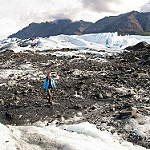

In [105]:
Image.open(dataset['path'].sample(1).values[0])

## Modelling

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)